## Project Proposal: 

# EVOLUTION of THOUGHTS 
# by DATA and TEXT MINING from SCHOLARLY LITERATURE

![workflow](workflow.png)

## Case Study #1: Exploratory data analysis with query = ‘global warming’

YOUR QUERY:  GLOBAL WARMING

Data mining in progress, acquiring:
                                   10000 of 10000 most relevant articles ... 

Premilinary statistics from data analysis


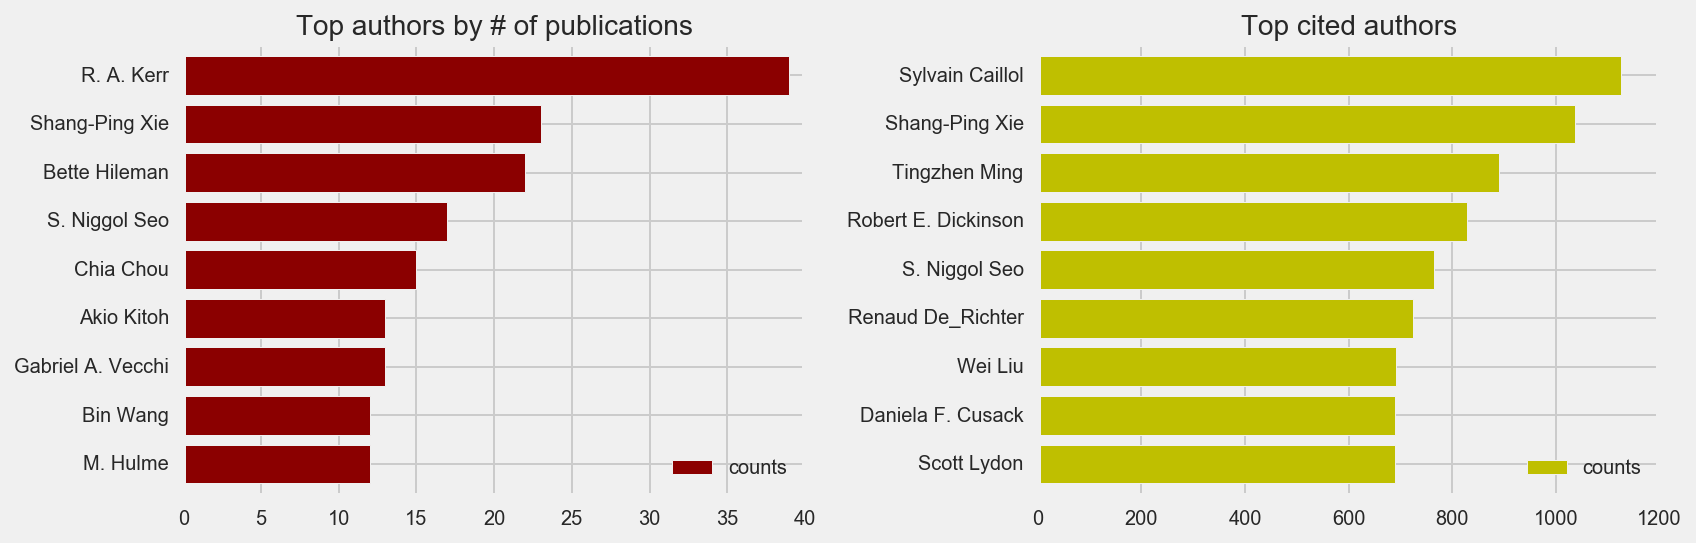

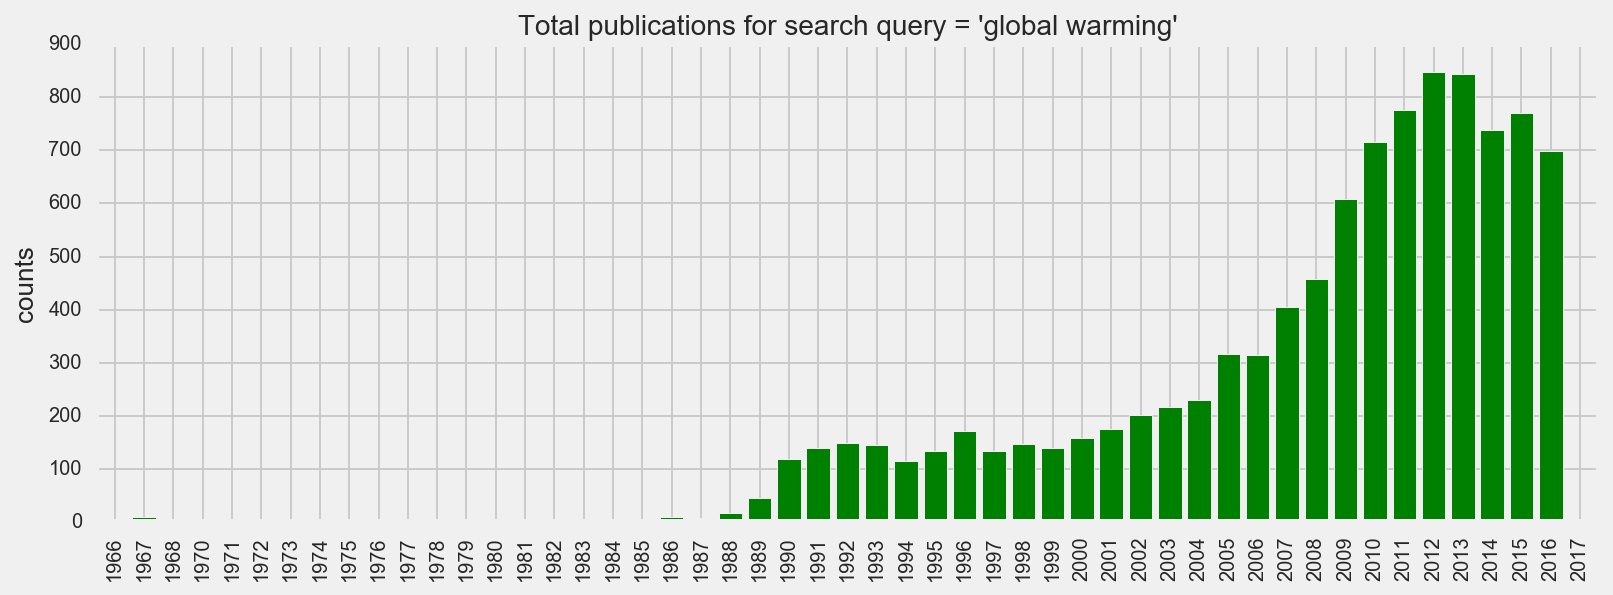


Running 50000 MCMC steps to estimate the expected number of publications per year
 [-----------------100%-----------------] 50000 of 50000 complete in 17.4 sec

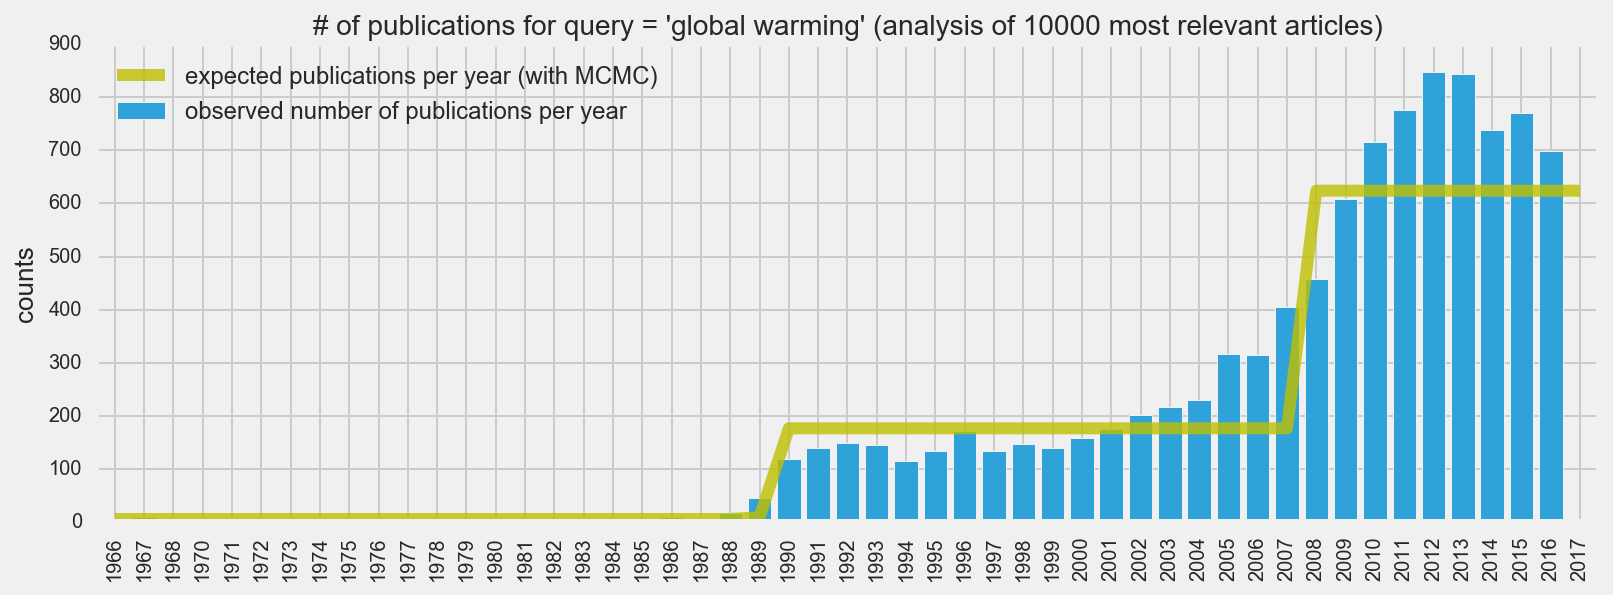


PRELIMINARY ANALYSIS of TEXT


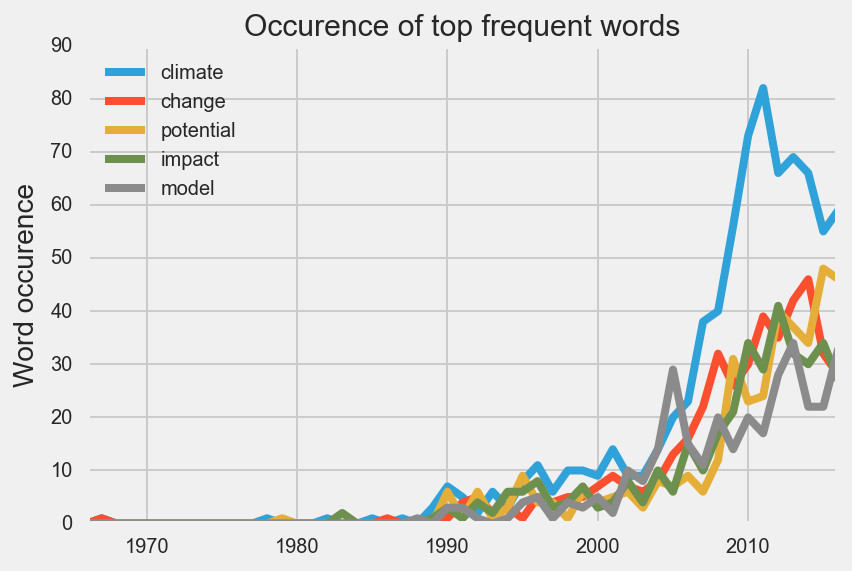


WORD CLOUD FOR YEARS BETWEEN 1966 and 1976


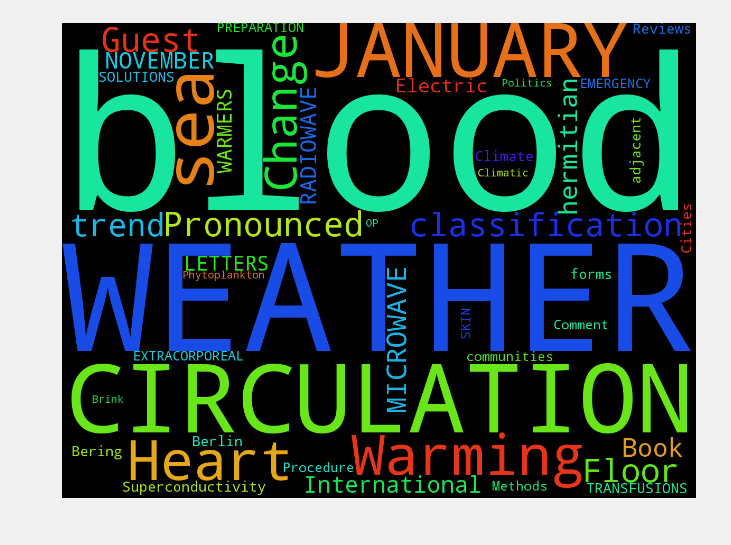


WORD CLOUD FOR YEARS BETWEEN 2006 and 2016


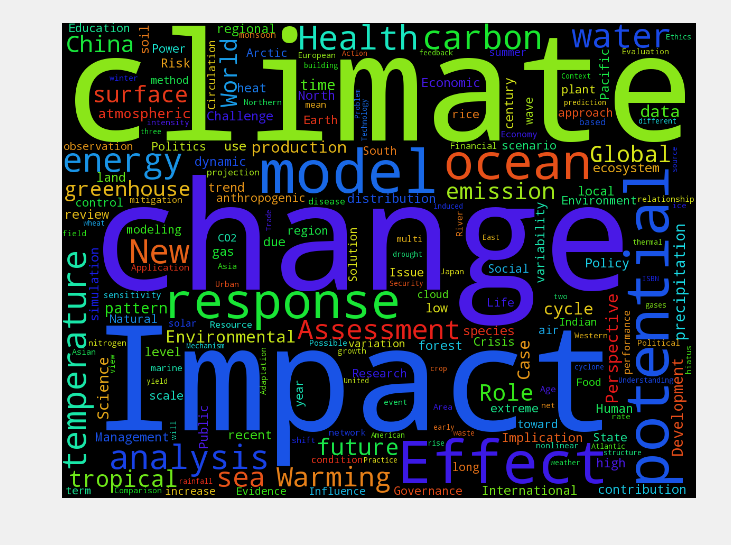

In [25]:
if __name__ == "__main__":
    df, text = main(query='global warming')

## Case Study #2: Exploratory data analysis with query = ‘neural networks’

YOUR QUERY:  NEURAL NETWORKS

Data mining in progress, acquiring:
                                   10000 of 10000 most relevant articles ...

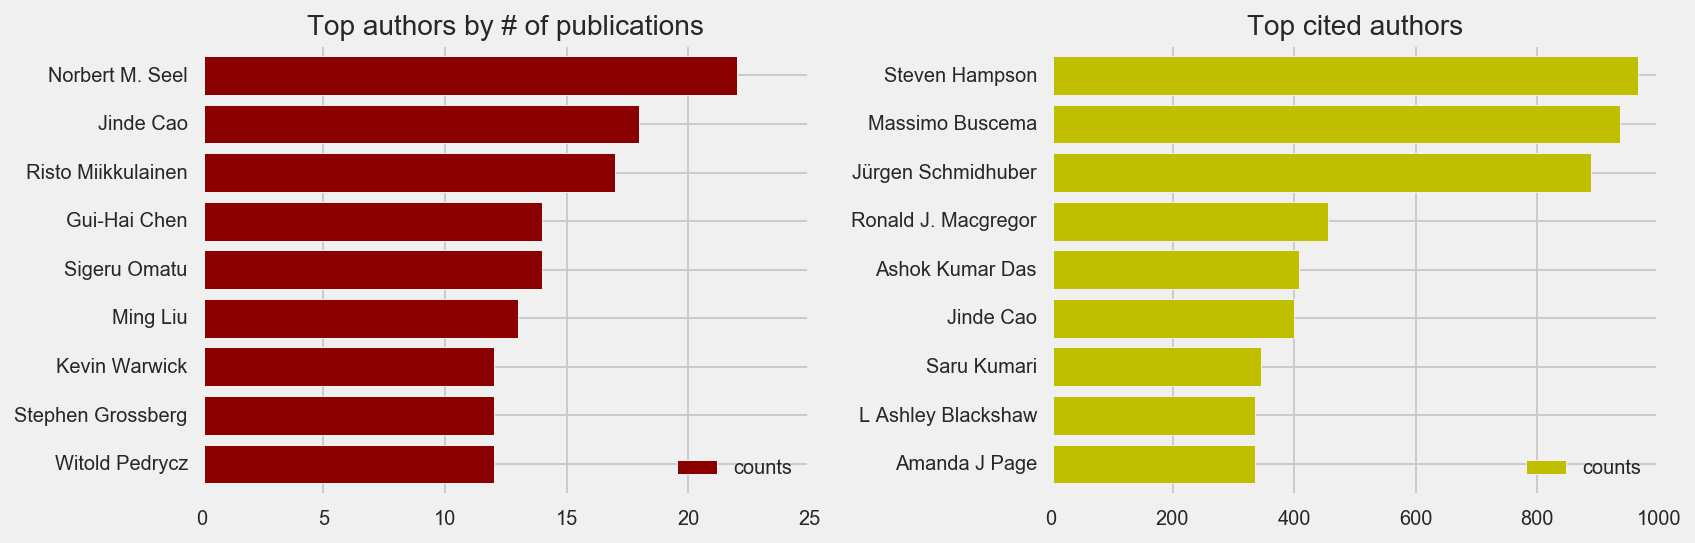

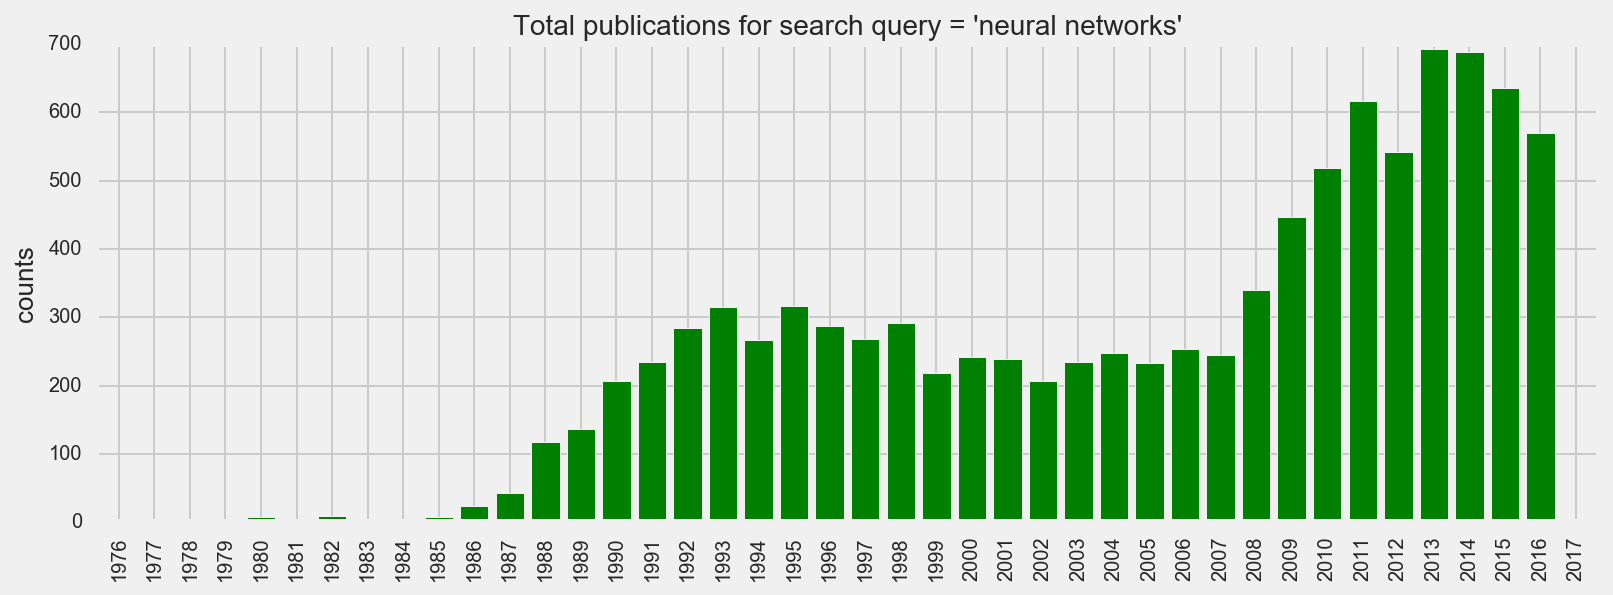

 
Running 50000 MCMC steps to estimate the expected number of publications per year
 [-----------------100%-----------------] 50000 of 50000 complete in 18.5 sec

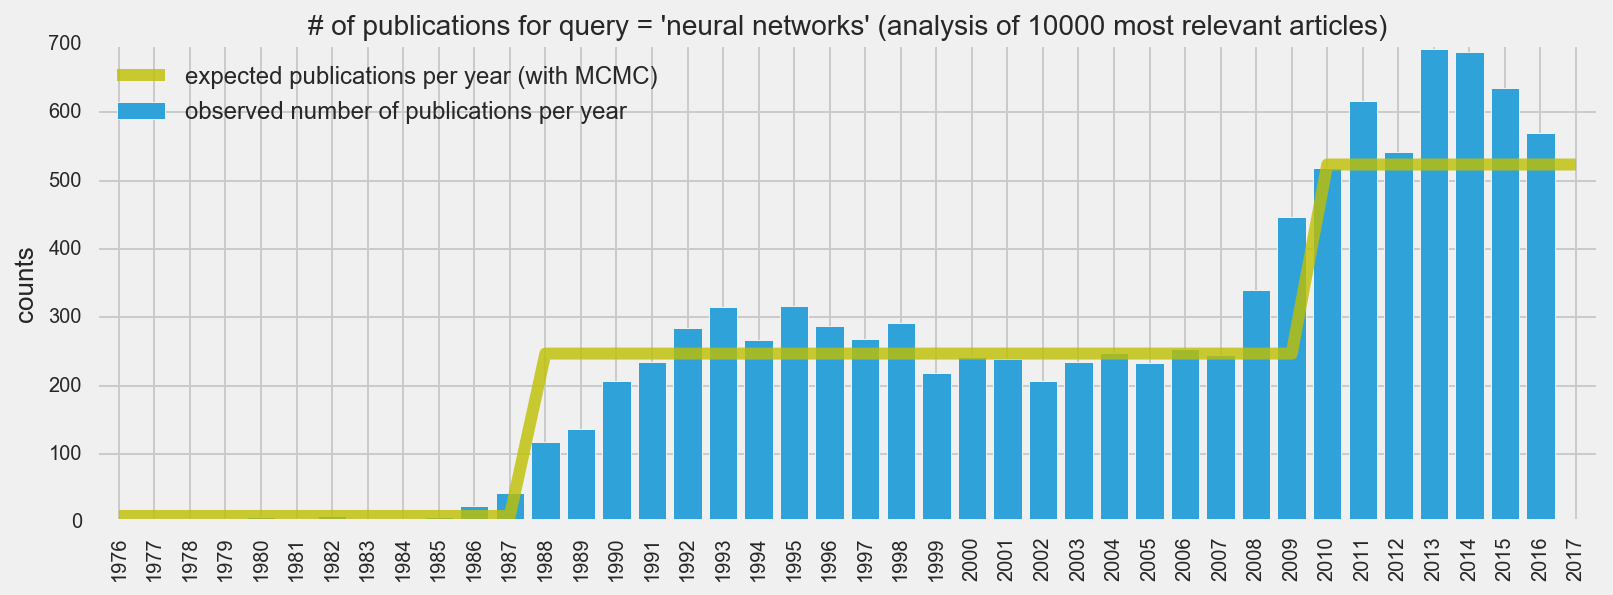


PRELIMINARY ANALYSIS of TEXT


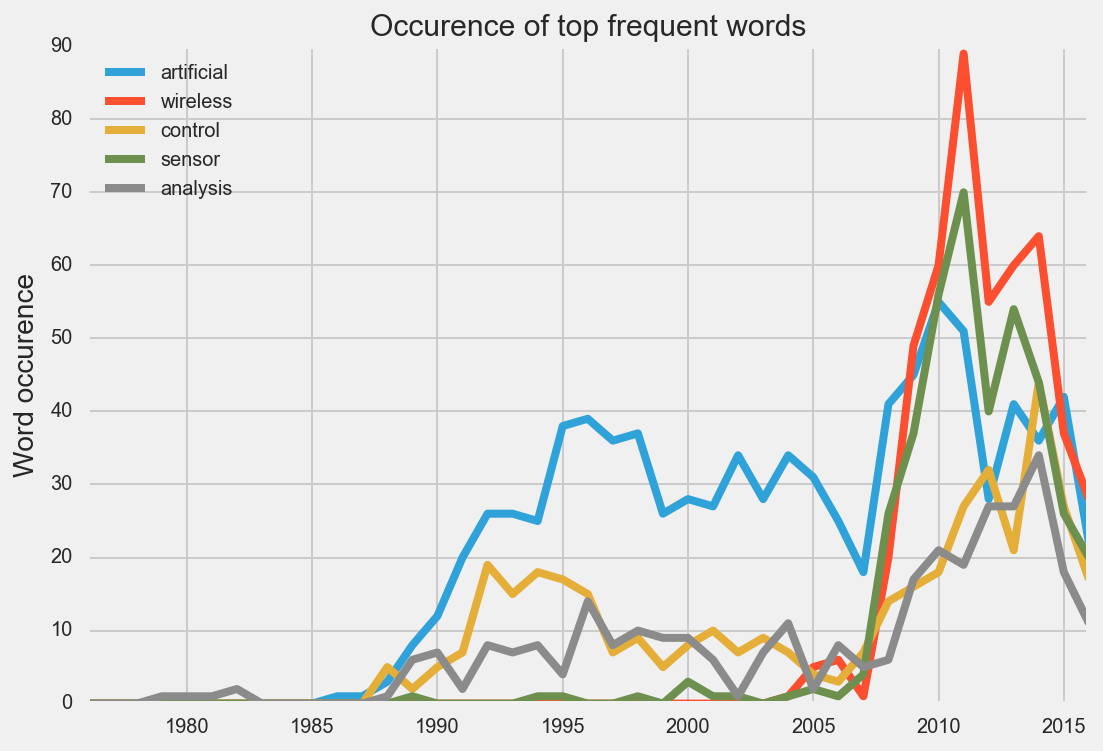


WORD CLOUD FOR YEARS BETWEEN 1976 and 1986


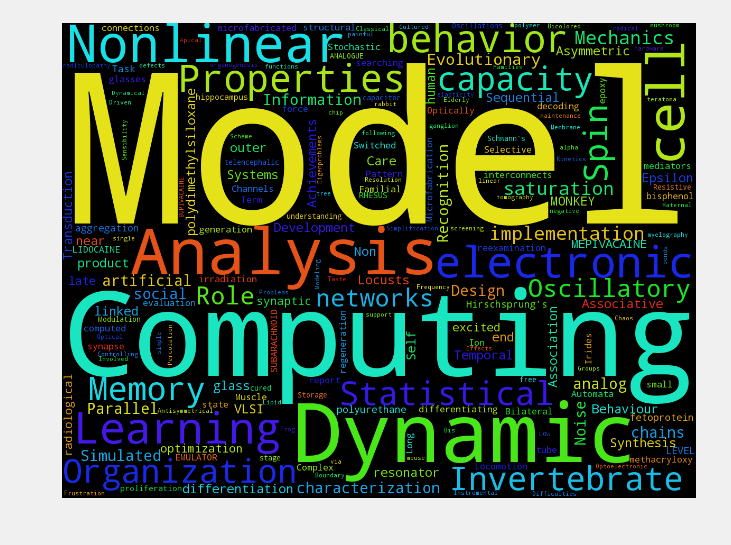


WORD CLOUD FOR YEARS BETWEEN 2006 and 2016


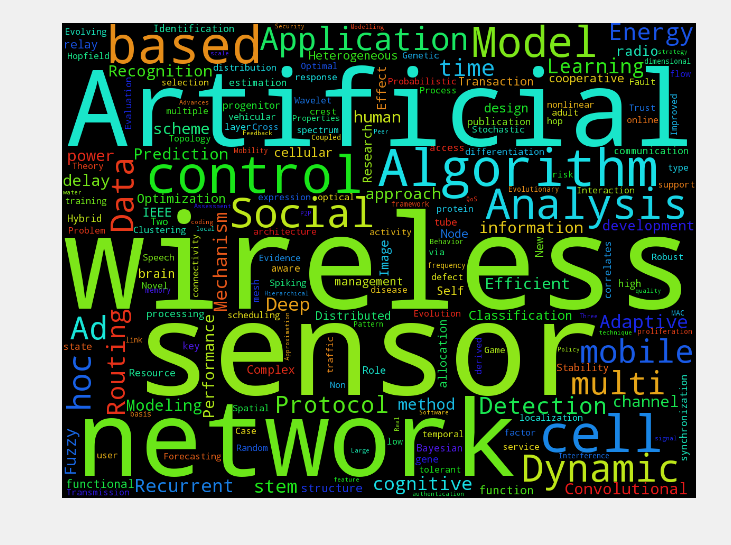

In [34]:
if __name__ == "__main__":
    df2, text2 = main(query='neural networks', years=40)

# CODING PART

### Loading modules

In [7]:
import pandas as pd
import json
import requests
from wordcloud import WordCloud, STOPWORDS
from datetime import date
import pymc
import numpy as np
import sys, string

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

### Functions 

In [8]:
def make_url(query, offset, rows, since):
    """a funtion to make the api url"""
        
    url = 'https://api.crossref.org/works?query.title={}&rows={}'.format(query,rows)
    url +='&offset={}'.format(offset)
    url +='&filter=from-pub-date:{}'.format(since)
    return url

In [9]:
url = make_url('smart windows', 0, 1000, 1966)
url

'https://api.crossref.org/works?query.title=smart windows&rows=1000&offset=0&filter=from-pub-date:1966'

In [10]:
def update_dicts(api_content, auth_nums, auth_cits, year_nums, year_text):
    """
    a function to extract data from each api query 
       and update them to dictionaries
    """
    
    for item in api_content:
        try:
            item['author']
            for author in item['author']:
                name = author['given'].title() + ' ' + author['family'].title()
                auth_nums[name] = auth_nums.get(name,0) + 1
                auth_cits[name] = auth_cits.get(name,0) + item['reference-count']
        except:
            pass
        
        year = item['issued'].values()[0][0][0]        
        year_text[year] = year_text.get(year, '') + ' ' + item['title'][0]
        year_nums[year] = year_nums.get(year, 0) + 1

    return auth_nums, auth_cits, year_nums, year_text

In [11]:
def add_stopwords(query):
    add_stop = query.lower().split() +\
        ['using', 'based', '-based', 'system', 'systems', 'study', 'studies']
    
    for p in ':,"?':
        for w in query.lower().split():
            add_stop.append(w+p)
    return add_stop

### Data storage and conversion to DataFrame

In [12]:
def make_df(dic):
    dic_df = pd.DataFrame( dic.values(), dic.keys())
    dic_df.columns = ['counts']
    return dic_df

### Initial Graphs

In [13]:
def plot_authors(nums_df, cits_df, howmany=-9,w=12.0, h=4.6):
    """ a funtion to plot top authors"""
        
    fig = plt.subplots(figsize=(w,h))

    ax1 = plt.subplot(121)
    nums_df = nums_df.sort_values(by='counts')
    nums_df[howmany:].plot(kind='barh', color='darkred', width=0.8, ax=ax1)

    plt.title('Top authors by # of publications', fontsize=14)
    
    ax2 = plt.subplot(122)
    cits_df = cits_df.sort_values(by='counts')
    cits_df[howmany:].plot(kind='barh', color='y', width=0.8, ax=ax2)

    plt.title('Top cited authors', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    return

In [14]:
def plot_year_nums(df, query, w=12, h=4):
    
    fig = plt.subplots(figsize=(w,h))
    
    df.counts.plot(kind='bar', width=0.8, color='g')
    
    plt.title('Total publications for search query = \'{}\''.\
              format(query.replace('+',' ').strip()), fontsize=14)
    plt.ylabel('counts', fontsize=13)
    plt.show()
    return

In [15]:
def plot_wordcloud(text_lst, add_stops, w=8, h=4):
        
    fig = plt.figure(figsize=(w,h)) 
    
    txt = string.translate( ' '.join(text_lst), string.punctuation)
    
    word_bag = ' '.join( [word for word in txt.split()
                         if word.lower() not in add_stops] )
    
    wordcloud = WordCloud(
                         stopwords=STOPWORDS,
                         background_color='black',
                         width=1200,
                         height=900).generate(word_bag)

    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    return

In [16]:
def word_counter(txt, add_stops):
    d = {}
    for word in txt.split():
        try: 
            word = word.encode('ascii').lower()
            word = word.translate(None, string.punctuation)
            
            if word not in STOPWORDS and word not in add_stops:
                d[word] = d.get(word,0) + 1
        except:
            continue
    lst = sorted(d.items(), key=lambda x: x[1], reverse=True)
    return lst

In [17]:
def plot_top_words(year_text,add_stops,n=5,w=5,h=3):
    txt = string.translate( ' '.join( year_text.values()), string.punctuation)
    popular = word_counter(txt, add_stops)[:n]
    
    common_words = {}
    for key in year_text.keys():
        for ii in range(5):
            word = popular[ii][0]
            c = year_text[key].lower().split().count(word)
            common_words[key] = common_words.get(key, []) + [c]
            
    common_words_df = pd.DataFrame(common_words).T
    common_words_df.columns = [popular[ii][0] for ii in range(5)]
#    print '\nOCCURENCE of TOP 5 FREQUENT WORDS'
#    plt.figure(figsize=[w,h])  
    common_words_df[:-1].plot()
    plt.ylabel('Word occurence', fontsize=14)
    plt.title('Occurence of top frequent words', fontsize=15)
    plt.show()
    return

### MCMC simulations (with PYMC) of expected publication numbers per year

In [18]:
def mcmc_jump2(data, lim, query, mc_steps=30000):
    fig = plt.subplots(figsize=(12,4))
    n_year = len(data)

    alpha = 1.0 / data.mean() 
    lambda_1 = pymc.Exponential("lambda_1", alpha)
    lambda_2 = pymc.Exponential("lambda_2", alpha)
    lambda_3 = pymc.Exponential("lambda_3", alpha)

    tau1 = pymc.DiscreteUniform("tau1", lower=0, upper=n_year) 
    tau2 = pymc.DiscreteUniform("tau2", lower=0, upper=n_year)

    @pymc.deterministic
    def lambda_(tau1=tau1, tau2=tau2, lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
        out = np.zeros(n_year)
        out[:tau1]     = lambda_1  # lambda before tau is lambda1
        out[tau1:tau2] = lambda_2  # lambda after (and including) tau is lambda2
        out[tau2:]     = lambda_3
        return out 
    
    observation = pymc.Poisson("obs", lambda_, value=data, observed=True)
    model = pymc.Model([observation, lambda_1, lambda_2, lambda_3, tau1, tau2]) 
    
    print ('\nRunning {} MCMC steps to estimate the expected number of publications per year'.\
           format(mc_steps))
    mcmc = pymc.MCMC(model)
    mcmc.sample(mc_steps, 10000, 1)

    lambda_1_samples = mcmc.trace('lambda_1')[:]
    lambda_2_samples = mcmc.trace('lambda_2')[:]
    lambda_3_samples = mcmc.trace('lambda_3')[:]

    tau1_samples = mcmc.trace('tau1')[:]
    tau2_samples = mcmc.trace('tau2')[:]   

    N = tau1_samples.shape[0]
    
    expected_per_year = np.zeros(n_year)

    for year in range(n_year):
        ix1 = year < tau1_samples
        ix3 = year > tau2_samples
        ix2 = ~(ix1 + ix3)

        expected_per_year[year] = (lambda_1_samples[ix1].sum() + lambda_2_samples[ix2].sum()
                                  + lambda_3_samples[ix3].sum()) / N
        

    plt.title('# of publications for query = \'{}\' (analysis of {} most relevant articles)'.\
                  format(query, lim), fontsize=14)

    data.plot(kind='bar', width=0.8,\
                    label="observed number of publications per year")

    plt.plot(range(n_year), expected_per_year, lw=6, color="y", alpha=0.8,
                 label="expected publications per year (with MCMC)")
    plt.ylabel('counts', fontsize=13)
    plt.legend(loc="best", fontsize=12)
    plt.show()    
    return

### Code body

In [22]:
def get_api_data(query, lim, since):
    query = '+' + query.replace(' ','+')
    
    rows = 1000
    auth_nums = {}
    auth_cits = {}
    year_nums = {}
    year_text = {}    
    
    print "\nData mining in progress, acquiring:"
    for offset in range(0, lim, rows):
        print '\r', ' '*34, '{} of {} most relevant articles ...'.format(offset+rows,lim),

        url = make_url(query, offset, rows, since)

        try:
            json_dict = json.loads(requests.get(url).text) 
            api_content = json_dict['message']['items']
            auth_nums, auth_cits, year_nums, year_text=\
                 update_dicts(api_content, auth_nums, auth_cits, year_nums, year_text)

        except:
            print '\r', ' '*34, '... oops! connection timeout :(',
            continue

    try:
        auth_nums_df = make_df(auth_nums)
        auth_cits_df = make_df(auth_cits)
        year_nums_df = make_df(year_nums)
        
    except:
        print ('\nAPI issues, data mining was unsuccesful, please try again later')
        sys.exit(0)
        
#    print '\nThe analysis for your searh query was finished, a report will now be prepared'
    
    return auth_nums_df, auth_cits_df, year_nums_df, year_text

In [24]:
def main(query, lim=10000, years=50, mc_steps=50000):
    
    today = date.today().year
    since = today - years
    
#    query = str(raw_input('Your query: '))
    
    print 'YOUR QUERY: ', query.upper()
    add_stops = add_stopwords(query)
            
    auth_nums_df, auth_cits_df, year_nums_df, year_text = get_api_data(query,lim,since)
    
    print '\n\nPremilinary statistics from data analysis'    
    plot_authors(auth_nums_df, auth_cits_df, howmany=-9, w=12.0, h=4.0)
    plot_year_nums(year_nums_df, query, w=12.0, h=4.0)
    
    mcmc_jump2(year_nums_df.counts, lim, query, mc_steps)
    
    print '\nPRELIMINARY ANALYSIS of TEXT'    
    year_text_df = make_df(year_text)
    plot_top_words(year_text,add_stops,n=5,w=7,h=4)
    
    print "\nWORD CLOUD FOR YEARS BETWEEN {} and {}".format(today-50, today-40)
    plot_wordcloud(year_text_df[-50:-40].counts, add_stops, w=8, h=4)
    
    print "\nWORD CLOUD FOR YEARS BETWEEN {} and {}".format(today-10, today)
    plot_wordcloud(year_text_df[-10:].counts, add_stops, w=8, h=4)  
    
    return year_nums_df, year_text